## Music Sales

In [2]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

def run_query(q):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q, conn)
    
def run_command(c):
    with sqlite3.connect('chinook.db') as conn:
        conn.islotaion_level = None
        conn.execute(c)
        
def show_tables():
    q = """
    SELECT
        name,
        type
    FROM sqlite_master
    WHERE type IN ("table","view");
    """
    return run_query(q)

show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


## Selecting New Albums to Purchase

In [3]:
genre_sales = """
WITH tracks_sold_usa AS
    (
    SELECT il.* FROM invoice_line il
    INNER JOIN invoice i ON i.invoice_id = il.invoice_id
    WHERE i.billing_country = "USA"
    )

SELECT
    g.name genre,
    COUNT(tsa.invoice_line_id) tracks_sold,
    CAST(COUNT(tsa.invoice_line_id) as FLOAT)/(
        SELECT COUNT(*) from tracks_sold_usa
    ) percentage_of_sold
FROM tracks_sold_usa tsa
INNER JOIN track t ON tsa.track_id = t.track_id
INNER JOIN genre g ON t.genre_id = g.genre_id
GROUP BY 1
ORDER BY 2 DESC
LIMIT 10
"""

run_query(genre_sales)

,genre,tracks_sold,percentage_of_sold
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Latin,22,0.020932
7,Pop,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


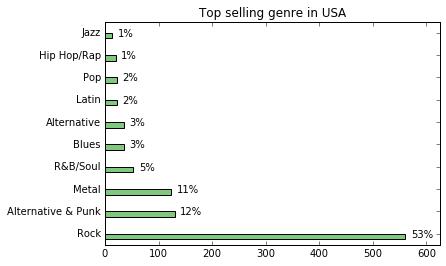

In [6]:
genre_sales_usa = run_query(genre_sales)
genre_sales_usa.set_index("genre", inplace=True, drop=True)

genre_sales_usa.plot.barh(
    title = "Top selling genres in USA",
    xlim = (0,625),
    colormap = plt.cm.Accent
)

for i, row in enumerate(list(genre_sales_usa.index)):
    score = genre_sales_usa.loc[row, 'tracks_sold']
    label = (genre_sales_usa.loc[row, 'percentage_of_sold'] * 100
            ).astype(int).astype(str) + "%"
    plt.annotate(str(label), (score + 10, i-0.15))

plt.legend().set_visible(False)
plt.ylabel("")
plt.show()

Based on USA sales data, we should purchase new albums by the following artists (in order):

- Red Tone (Punk)
- Slim Jim Bites (Blues)
- Meteor and the Girls (Pop)

However, it's worth noting that these three genres combined only make up 17% of total sales. Perhaps, we should look out for artists and albums from the 'rock' genre, which accounts for more than half of sales.

## Analyzing Employee Sales Performance

In [7]:
sales_results = """
WITH customer_spending AS 
    (
    SELECT
        c.customer_id customer_id,
        c.support_rep_id support_rep_id,
        SUM(i.total) total_spent
    FROM customer c
    INNER JOIN invoice i ON c.customer_id = i.customer_id
    GROUP BY 1    
    )
    
SELECT
    e.first_name || " " || e.last_name employee_name,
    SUM(cs.total_spent) total_sales,
    e.hire_date date_of_hire
FROM employee e
LEFT JOIN customer_spending cs 
ON e.employee_id = cs.support_rep_id
GROUP BY 1
ORDER BY 2 DESC
LIMIT 3
"""

run_query(sales_results)

,employee_name,total_sales,date_of_hire
0,Jane Peacock,1731.51,2017-04-01 00:00:00
1,Margaret Park,1584.00,2017-05-03 00:00:00
2,Steve Johnson,1393.92,2017-10-17 00:00:00


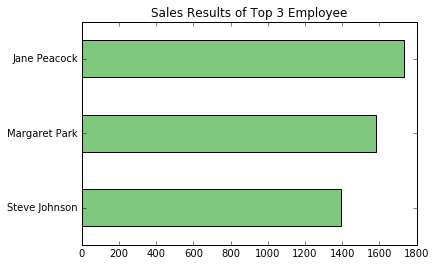

In [9]:
employee_sales_results = run_query(sales_results)

employee_sales_results.set_index("employee_name", inplace=True, drop=True)
employee_sales_results.sort_values("total_sales", inplace=True)
employee_sales_results.plot.barh(
    legend = False,
    title = "Sales Results of Top 3 Employee",
    xlim = (0,1800),
    colormap = plt.cm.Accent
)

plt.ylabel("")
plt.show()

Sales difference roughly corresponds with length of employment.

## Analysing Sales by Country

In [16]:
country_sales_data="""
WITH country_or_other AS
    (
     SELECT
       CASE
           WHEN (
                 SELECT count(*)
                 FROM customer
                 where country = c.country
                ) = 1 THEN "Other"
           ELSE c.country
       END AS country,
       c.customer_id,
       il.*
     FROM invoice_line il
     INNER JOIN invoice i ON i.invoice_id = il.invoice_id
     INNER JOIN customer c ON c.customer_id = i.customer_id
    )
    
SELECT
    country,
    COUNT(DISTINCT customer_id) total_customers,
    SUM(unit_price) total_sales,
    ROUND(SUM(unit_price)/ COUNT(DISTINCT customer_id),2) avg_value
FROM country_or_other
GROUP BY 1
ORDER BY 3 DESC
"""

run_query(country_sales_data)

,country,total_customers,total_sales,avg_value
0,Other,15,1094.94,73.00
1,USA,13,1040.49,80.04
2,Canada,8,535.59,66.95
3,Brazil,5,427.68,85.54
4,France,5,389.07,77.81
5,Germany,4,334.62,83.66
6,Czech Republic,2,273.24,136.62
7,United Kingdom,3,245.52,81.84
8,Portugal,2,185.13,92.57
9,India,2,183.15,91.58


## Visualising Sales by Country

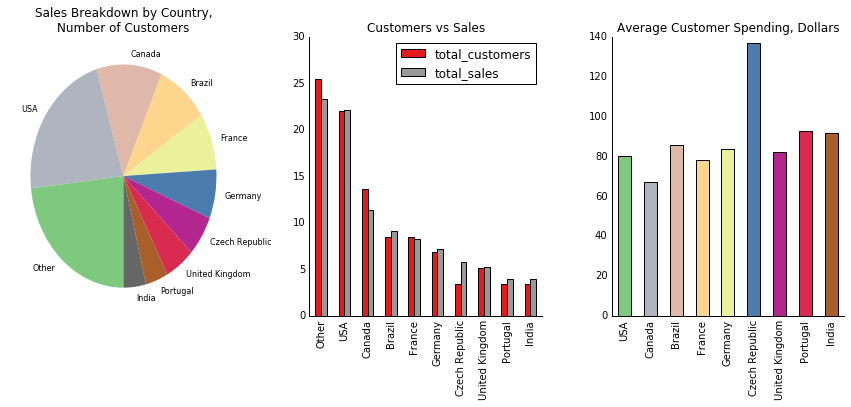

In [27]:
country_metrics = run_query(country_sales_data)
country_metrics.set_index("country", drop=True, inplace=True)
colors = [plt.cm.Accent(i) for i in np.linspace(0, 1, country_metrics.shape[0])]

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
ax1, ax2, ax4 = axes.flatten()
fig.subplots_adjust(hspace=.5, wspace=.3)


#First
sales_breakdown = country_metrics["total_sales"].copy().rename('')
sales_breakdown.plot.pie(
    ax=ax1,
    startangle=-90,
    counterclock=False,
    title='Sales Breakdown by Country,\nNumber of Customers',
    colormap=plt.cm.Accent,
    fontsize=8,
    wedgeprops={'linewidth':0}
    
)

#Second
cvd_cols = ["total_customers","total_sales"]
custs_vs_dollars = country_metrics[cvd_cols].copy()
custs_vs_dollars.index.name = ''
for c in cvd_cols:
    custs_vs_dollars[c] /= custs_vs_dollars[c].sum() / 100
custs_vs_dollars.plot.bar(
    ax=ax2,
    colormap=plt.cm.Set1,
    title="Customers vs Sales"
)
ax2.tick_params(top="off", right="off", left="off", bottom="off")
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)

#Third
ltv = country_metrics["avg_value"].copy()
ltv.index.name = ''
ltv.drop("Other",inplace=True)
ltv.plot.bar(
    ax=ax4,
    color=colors,
    title="Average Customer Spending, Dollars"
)
ax4.tick_params(top="off", right="off", left="off", bottom="off")
ax4.spines["top"].set_visible(False)
ax4.spines["right"].set_visible(False)

plt.show()